In [1]:
import sys, time
sys.path.insert(0, "..")

import torch
import matplotlib.pyplot as plt
import numpy as np
from src.pinns import PINN
from src.utils.visualization import TrainingDataVisualizer as TDV

In [2]:
# reproducibility
torch.manual_seed(31)

In [3]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch.autograd as autograd
# Example 1: 2D p-poisson equation
def pde_residual(coords, u_pred):
    """
    Compute the residual of the 2D p-Laplacian Poisson equation

        −∇·( |∇u|^(p-2) ∇u ) = 1

    Args:
        coords (torch.Tensor): shape (N,2) input points (x,y), requires_grad=True
        u_pred (torch.Tensor): shape (N,1) model's predicted u at coords

    Returns:
        torch.Tensor: PDE residual r(x,y) = −∇·( |∇u|^(p-2) ∇u ) - 1
    """
    p = 2.0  # p-Laplacian exponent
    # 1) Compute gradient ∇u = (∂u/∂x, ∂u/∂y)
    u_grad = autograd.grad(
        outputs=u_pred,
        inputs=coords,
        grad_outputs=torch.ones_like(u_pred).to(device),
        retain_graph=True,
        create_graph=True
    )[0]
    u_grad_x = u_grad[:, 0]
    u_grad_y = u_grad[:, 1]

    # 2) Compute |∇u|^(p−2)
    grad_norm_power = (u_grad_x**2 + u_grad_y**2)**((p - 2) / 2)

    # 3) Form flux q = |∇u|^(p−2) ∇u
    flux_x = grad_norm_power * u_grad_x
    flux_y = grad_norm_power * u_grad_y

    # 4) Compute divergence ∇·q = ∂q_x/∂x + ∂q_y/∂y
    div_q_x = autograd.grad(
        outputs=flux_x,
        inputs=coords,
        grad_outputs=torch.ones_like(flux_x).to(device),
        retain_graph=True,
        create_graph=True
    )[0][:, 0]
    div_q_y = autograd.grad(
        outputs=flux_y,
        inputs=coords,
        grad_outputs=torch.ones_like(flux_y).to(device),
        retain_graph=True,
        create_graph=True
    )[0][:, 1]

    p_laplacian = div_q_x + div_q_y

    # 5) PDE residual: −∇·( |∇u|^(p−2) ∇u ) − 1
    return -p_laplacian - 1


In [5]:
# 2) instantiate PINN
model = PINN(
    pde_residual=pde_residual,
    input_dim=2,
    hidden_dim=50,
    output_dim=1,
    num_hidden_layers=4,
    Nd=50, # number of boundary points
    Nc=1000, # number of collocation points
    device=device
)
model.double()  # convert model to double precision
model.to(device)
print("Using device:", next(model.parameters()).device)


Using device: cpu


In [6]:
# grab the data generated in PINN.__init__
x_train_Nu = model.x_train_Nu
u_train_Nu = model.u_train_Nu
x_train_Nf = model.x_train_Nf

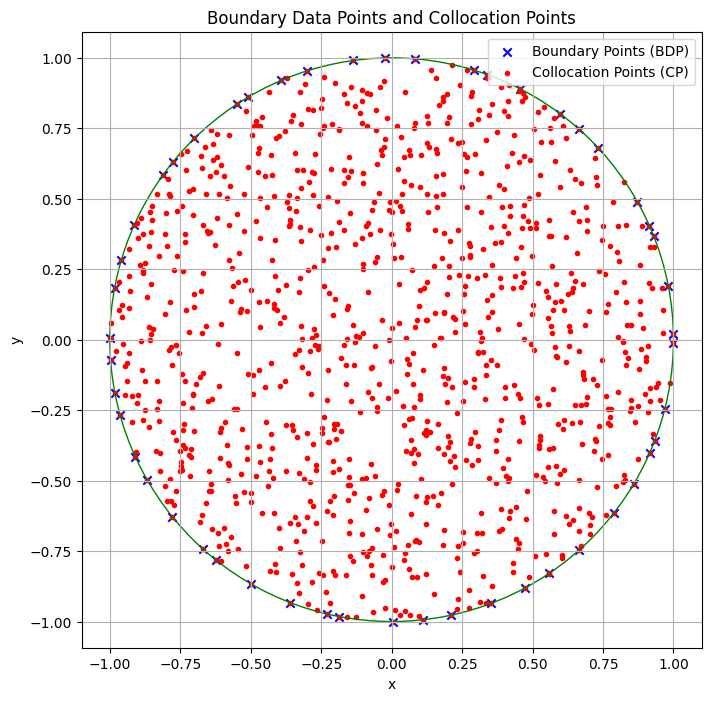

In [7]:
TDV.visualize_training_data(x_train_Nu, x_train_Nf)

In [8]:
pi = torch.tensor(np.pi, dtype=torch.float).to(device)

In [9]:
epochs = 0
loss_values1 = 1
loss_values2 = 1
error = 1
loss_values = []

In [10]:
start_time = time.time()
while loss_values2 > 1e-4:
    loss = model(bc_weight=10)
    loss_values.append(loss.item())

    if epochs == 0:
        print("Training Loss ----- Test Loss")
        loss_values1 = 1
        loss_values2 = loss_values[0]
        error = ((loss_values2 - loss_values1)**2)
    else:
        loss_values1 = loss_values[epochs-1]
        loss_values2 = loss_values[epochs]
        error = ((loss_values2 - loss_values1)**2)

    if epochs % 500 == 0:
        print(epochs,'-',loss)

    epochs += 1

c:\Users\gh_ab\PINNs\notebooks\..\src\training\losses.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(x_train_Nf, dtype=torch.float64, device=device)
c:\Users\gh_ab\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1050, 1])) that is different to the input size (torch.Size([1050])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Loss ----- Test Loss
0 - tensor(1.0265, dtype=torch.float64, grad_fn=<AddBackward0>)
500 - tensor(0.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
1000 - tensor(0.0001, dtype=torch.float64, grad_fn=<AddBackward0>)
1500 - tensor(0.0002, dtype=torch.float64, grad_fn=<AddBackward0>)
2000 - tensor(0.0001, dtype=torch.float64, grad_fn=<AddBackward0>)


In [11]:
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

Training time: 116.56


In [12]:
loss_values

[1.0265319286767023,
 0.9973905511545543,
 0.970482478125065,
 0.9443018662115928,
 0.9173770906748062,
 0.8885867954980441,
 0.8572506856619718,
 0.8228615065273112,
 0.7849035704086919,
 0.742884863352551,
 0.6965498376693183,
 0.6458875519372169,
 0.5909160726829945,
 0.5316512250644213,
 0.4685416052596411,
 0.4027468890098713,
 0.3364804700152192,
 0.2731319136728526,
 0.21629129677030712,
 0.17084310447757609,
 0.14328968229226247,
 0.13602454848072065,
 0.14682848283472952,
 0.16524046227808495,
 0.1791054977592164,
 0.18269516121998539,
 0.16640098501646466,
 0.14025779545090927,
 0.1203961130513517,
 0.09505039070884894,
 0.08458244496774613,
 0.07169902232661315,
 0.07079167991517471,
 0.06838277039480485,
 0.07215413774471689,
 0.07241918993092587,
 0.07484790856570682,
 0.07413547210401433,
 0.07248813344851758,
 0.06917935776450021,
 0.0642399340360066,
 0.059282244845622764,
 0.05318787610341938,
 0.048527196575227464,
 0.04415156475002766,
 0.04121496551933515,
 0.039968